Genetic Algorithm
Basic Flowline:

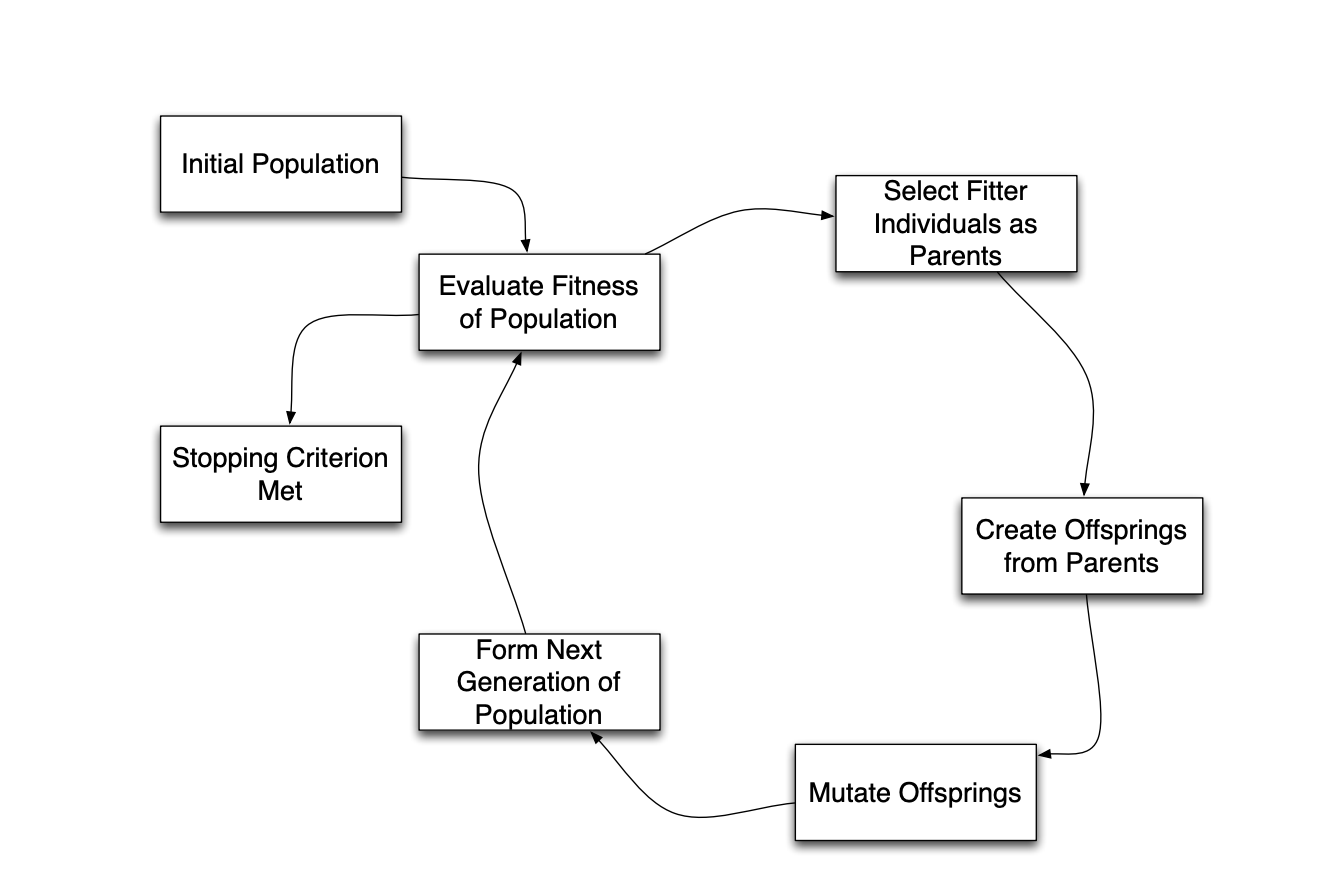
유신 교수님 다른 수업에서 가져온 GA 기본 flow 입니다. 참고하시면 좋을 것 같네요

**1. Initial Population**

INPUT: greedy_suite, population
OUTPUT: initial population of test suites

: Given the test suite made by greedy - CIT, we make the inital population out of it.
Approach 1: randomly select from the test suite.
Approach 2: Do some good seeding using some algorithm

An example of greedy_suite: For parameter A, B, C of 0 or 1
(Example of greedy_suite): [[0, 0, 0], [0, 1, 1], [1, 0, 0]]

Then initial population with given budget may be something like this.
(With population 2 and budget 2)
(Example of initial population): [[[0, 0, 0], [0, 1, 1]] ,  [[0, 1, 1], [1, 0, 0]]]

==> 수정: 제가 TestSuite이라는 class 만들었습니다. 똑같은 녀석 굳이 fitness 계산 또 하게 만들지
않게 하기 위해서입니다. 이제 population은 여러개의 TestSuite 인스턴스로 구성됩니다

예시) initial_population = [TestSuite1, TestSuite2 ... ]

이제 TestSuite은 self.test_suite 과 self.fitness_value 두가지 필드를 가집니다.
self.test_suite은 이 녀석이 실제 표현하는 test_suite을 의미합니다. (ex) [[0, 0, 0], [0, 1, 1]]
self.fitness_value는 값이거나 None 입니다. 이미 한번이라도 fitness_evaluation이 되었으면 값을 가지고
처음 등장한 녀석이면 None입니다. fitness evaluation을 실제 진행할 때는 None인 녀석에 대해서면 fitness evaluation을 진행해 주시면 됩니다.

**2. Calculate Fitness**

INPUT: A population
OUTPUT: A list with scores. Each score represents the fitness of the given index gene.
형님께서 이거 작성하시고 어떻게 하는지 대략 적어주심 될 것 같습니다.
생각해 봤는데 사실 임의로 뽑아왔을 때 strength 2 만족하는 것도 힘들 것 같긴 해서 
strength 확인하는 함수 만드시는 것도 좋은데, 그거로 부족하고 각각 등장하는 숫자를 세는 등 다른 방법이 필요할 것 같습니다.

어떤 gene (population의 한 instance) 의 구성이 좀 다양하면 높은 fitness, 
어떤 gene 의 구성이 간단하면 낮은 fitness 를 갖게 하면 됩니다.

///population을 한 번 스캔해서 parameter list를 만듭니다.
parameter list로부터 [[2,strength_list[]], [3,strength_list[]] ... ]와 같이 리스트를 만듭니다.
list는 더 높은 strength가 요구될 때마다 업데이트하며 한 번 구한 strength list는 global list에 저장하여 필요없는 반복을 피합니다.
이후 각 test suite에 대해 evaluation을 진행하는데
0.hard constraint가 존재하면 score은 0으로 반환합니다.
1.strength level을 측정합니다.
2.달성한 최대 strength + 1의 리스트에 대하여 (test suite가 포함하는 조합)/{(전체 조합) * 100}을 하여 위 1번 값에 더합니다.
3.만약 soft constraint가 존재한다면 존재하는 soft constraint 개수*0.01을 2번 값에 더하여 동일 strength level에서 soft constraint가 더 많은 test suite가 높은 점수를 얻도록 합니다.

변경)
1. variety check
각 test suite에서 특정 value의 출현 횟수를 계산한다.
fitness value 값을 1로 설정한 후 출현횟수 * 파라미터 개수 / 테스트케이스 개수 (값이 너무 커지거나 너무 작아지는 것 방지)를 곱한다.
fitness value를 설정한다

2.soft constraint
soft constraint 조건에 해당하는 test case 하나당, fitness value에 1.3을 곱하여 priority를 증가시킨다

3.hard constarint
hard constraint 조건에 해당하는 test case가 존재하면, fitness value를 0으로 설정해 다음 generation selection시 무조건 탈락하게 한다.


**3. Make next generation**

Fitness result 결과를 보면서 다음 generation을 만든다.
40%는 엘리트로써 일단 그대로 가지고 간다. (이중 10%는 mutation도 하지 않는다)
40%는 상위 40%로부터 만들어진다.
나머지 20%는 랜덤으로 뽑는다.


In [27]:
import random

In [28]:
class TestSuite():
    def __init__(self, base, additional):
        self.base = base
        self.additional = additional
        self.fitness_value = None
        
    def assign_fitness_value(self, fitness_value):
        self.fitness_value = fitnes_value
        
    def make_test_suite(self):
        self.test_suite = self.base + self.additional
        
    def eval_variety(self, parameter_num, parameter_range):
        appear_time = []
        
        for ith_param in range(parameter_num):
            value_list = [1 for _ in range(parameter_range+1)]
            appear_time.append(value_list)
            
        for testcase in self.additional:
            for ind in range(len(testcase)):
                appear_time[ind][testcase[ind]] += 1
                
        score = 1
        for ith_param in appear_time:
            for ind in range(len(ith_param)):
                if ith_param[ind] != 1:
                    score = score * ((ith_param[ind]*parameter_num)/len(self.additional))
                    #prevent the fitness value become too big or too small for temprorary
                    #if there are better standard, need to modify
                
        self.fitness_value = score
    
    #assume soft_list format [constraint1 = [[parameter index,lower range, upper range], [], ...], constraint2 = []...]
    #if test case satisfy constraint condition, multiply fitness value 1.3
    def eval_soft_constraint(self, soft_list):
        for constraint in soft_list:
            for testcase in self.test_suite:
                for (ind, condition) in enumerate(constraint):
                    if testcase[condition[0]] < condition[1] or condition[2] < testcase[condition[0]]:
                        break
                    if ind == (len(constraint)-1):
                        self.fitness_value = self.fitness_value * 1.3
                    
        
    #hard_list format is same as soft_list
    #if test case satisfy hard constraint condition, set fitness value to 0 and return
    def eval_hard_constraint(self, hard_list):
        for constraint in hard_list:
            for testcase in self.test_suite:
                for (ind, condition) in enumerate(constraint):
                    if testcase[condition[0]] < condition[1] or condition[2] < testcase[condition[0]]:
                        break
                    if ind == (len(constraint)-1):
                        self.fitness_value = 0
                        return
                
    def print_fit_val(self):
        print(self.fitness_value)
                

In [29]:
class GA():
    # Range for budget
    # len(base) < budget == len(base) + len(additional) < len(greedy_suite)
    def __init__(self, greedy_suite, base, parameter_num, parameter_range, budget, population_num, mutation_rate):
        self.greedy_suite = greedy_suite
        self.base = base
        self.parameter_num = parameter_num
        # maximum value of the parameter
        self.parameter_range = parameter_range
        self.budget = budget
        self.mutation_rate = mutation_rate
        self.population_num = population_num
        self.fitness_result =[]
        self.population = []
        
        
    # must do this
    def delete_base_from_greedy(self):
        for i in range(len(self.base)):
            target = self.base[i]
            if(target in self.greedy_suite):
                self.greedy_suite.remove(target)
    # 수정 필요
    def initial_population(self):
        #Using Approach 1: randomly choosing from the greedy - test suite
        initial_population = []
        for i in range(self.population_num):
            gene = random.choices(self.greedy_suite, k = self.budget - len(self.base))
            new_suite = TestSuite(self.base, gene)
            initial_population.append(new_suite)
        self.population = initial_population
            
    def fitness_calculate(self, soft_list, hard_list):
        self.fitness_result = []
        for i in range(self.population_num):
            self.population[i].eval_variety(self.parameter_num, self.parameter_range)
            self.population[i].eval_soft_constraint(soft_list)
            self.population[i].eval_hard_constraint(hard_list)
            self.fitness_result.append(self.population[i].fitness_value)
    
    def select_parent(self):
        return random.choices(self.population, weights = self.fitness_result, k = 2)
    
    
    def make_children(self, parent1, parent2):
        #Sort the list lexicographically
        # For now, just take half / half
        sorted_parent1 = sorted(parent1.additional, key = lambda elem: elem)
        sorted_parent2 = sorted(parent2.additional, key = lambda elem: elem)
        
        child1 = []
        child2 = []
        assert(self.budget - len(self.base) == len(parent1.additional))
        assert(self.budget - len(self.base) == len(parent2.additional))
        additional_length = self.budget - len(self.base)
        for i in range(additional_length):
            if(i < int(additional_length / 2)):
                child1.append(sorted_parent1[i])
                child2.append(sorted_parent2[i])
            else:
                child1.append(sorted_parent2[i])
                child2.append(sorted_parent1[i])
                
                
        #TODO
        #compare the fitness value of both and return the better child
        # for now, just return child
        return child1
    
    def mutate_test_suite(self, test_suite):
        #iterate for each parameter
        mutant = []
        for i in range(len(test_suite[0])):
            new_dict = {}
            for j in range(len(test_suite)):
                if(test_suite[j][i] not in new_dict.keys()):
                    new_dict[test_suite[j][i]] = 0
                else:
                    new_dict[test_suite[j][i]] = new_dict[test_suite[j][i]] + 1
            minimum_cnt = -1
            minimum_var = None
            for j in range(len(new_dict.keys())):
                temp = list(new_dict.keys())[j]
                temp_cnt = new_dict[temp]
                if(minimum_cnt < 0 or temp_cnt < minimum_cnt):
                    minimum_cnt = temp_cnt
                    minimum_var = temp
            
            mutant.append(minimum_var)
        del test_suite[0]
        test_suite.append(mutant)
        return test_suite
        
    def mutate_population(self, new_population):
        sorted_population = sorted(self.population, key = lambda test_suite: test_suite.fitness_value)
        mutated_population = []
        for i in range(len(sorted_population)):
            target_test_suite = sorted_population[i].additional
            if(random.random() < self.mutation_rate):
                new_test_suite = self.mutate_test_suite(target_test_suite)
                mutated_population.append(TestSuite(self.base, new_test_suite))
            else:
                mutated_population.append(TestSuite(self.base, target_test_suite))
                
        return mutated_population
                
    def next_generation(self):
        elite_num = int(self.population_num * 4 / 10)
        children_num = int(self.population_num * 4 / 10)
        random_children_num = self.population_num - elite_num - children_num
        
        sorted_population = sorted(self.population, key = lambda test_suite: test_suite.fitness_value)   
        elite_children = sorted_population[self.population_num - elite_num:]
        print(sorted_population[-1].fitness_value)
        children = []
        for i in range(children_num):
            [parent1, parent2] = self.select_parent()
            child = self.make_children(parent1, parent2)
            children.append(TestSuite(self.base, child))
            
        random_children = []
        for i in range(random_children_num):
            random_child = random.choice(self.population)
            random_children.append(random_child)
            
        new_population = elite_children + children + random_children
        
        mutated_population = self.mutate_population(new_population)
        
        self.population = mutated_population
        
    
    

In [44]:
from greedy import greedy_cit

In [50]:
a = greedy_cit(2, ["a1", "a2", "a3"], [5, 5, 5])
b = greedy_cit(3, ["a1", "a2", "a3"], [5, 5, 5])
print(len(a))
print(len(b))

3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
30
125


In [33]:
temp = GA(b, a, 3, 5, 100, 1000, 0.5)

In [34]:
temp.delete_base_from_greedy()

In [35]:
temp.initial_population()

In [36]:
for i in range(100):
    temp.fitness_calculate([],[])
    temp.next_generation()

        

0.0012614057122291463
0.0012614057122291463
0.001278528866693795
0.001278528866693795
0.001278528866693795
0.0012797928596415895
0.0013008098661057297
0.0013008098661057297
0.001311741041451156
0.001311741041451156
0.001311741041451156
0.001311741041451156
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.0013234791578337214
0.001323479157833

In [37]:
lf, greedy_suite, base, parameter_num, parameter_range, budget, population_num, mutation_rate):

SyntaxError: unmatched ')' (<ipython-input-37-bcb3016b33b3>, line 1)

In [38]:
temp.next_generation()

TypeError: '<' not supported between instances of 'NoneType' and 'NoneType'

In [39]:
temp.fitness_calculate([],[])

In [40]:
a = [1,2,3,4,5]

In [41]:
a[2:]

[3, 4, 5]